<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_HCP_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Setup cell ---

# 1️⃣ Mount Google Drive (for data)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Clone GitHub repository (for code)
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# 3️⃣ Define paths
import os, sys

repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")

sys.path.append(repo_dir)

# 4️⃣ Import packages
import numpy as np
import matplotlib.pyplot as plt
import torch
from src import NPI
import gc

# 5️⃣ Check device
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Running on:", torch.cuda.get_device_name(0))
else:
    print("⚠️  GPU not detected — training will run on CPU.")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 253 (delta 35), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (253/253), 29.46 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (76/76), done.
PyTorch version: 2.9.0+cu126
CUDA available: True
Running on: Tesla T4


In [ ]:
# --- Training parameters ---

# Choose ANN architecture: 'MLP', 'CNN', 'RNN', or 'VAR'
method = "MLP"

# Model and training hyperparameters
ROI_num = 450
using_steps = 3
batch_size = 64
train_set_proportion = 0.9
num_epochs = 50
learning_rate = 5e-4
l2_reg = 5e-5

print(f"Training configuration:")
print(f"  Method: {method}")
print(f"  Regions: {ROI_num}")
print(f"  Steps: {using_steps}")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")

Training configuration:
  Method: MLP
  Regions: 450
  Steps: 3
  Epochs: 50
  Batch size: 64


### Understanding `signals`, `inputs`, and `targets`

Let **T** = total number of time points and **S** = number of past steps.

---

**`signals`**  
- Shape: **(T, N)**  
- Preprocessed fMRI time series (after removing first 30 TRs, filtering, and concatenating runs).  
- `signals[t, n]` = BOLD activity of region *n* at time *t*.

---

**`inputs`**  
- Shape: **(T − S, N × S)**  
- Each row contains the flattened activity of all N regions over the past S time points.  
- Represents the temporal context used for prediction.

---

**`targets`**  
- Shape: **(T − S, N)**  
- Each row is the brain activity at the next time point following the input window.  
- What the model aims to predict.


In [ ]:
# --- Train a model for each subject ---
results = {}

weights_dir = os.path.join(preproc_dir, f"trained_models_{method}")
os.makedirs(weights_dir, exist_ok=True)

for sid in subject_ids:
    print(f"🚀 Training model for subject {sid} ({method})")

    # Load data
    inputs = np.load(os.path.join(preproc_dir, f"{sid}_inputs.npy"))
    targets = np.load(os.path.join(preproc_dir, f"{sid}_targets.npy"))

    # Initialize and train
    model = NPI.build_model(method, ROI_num, using_steps)
    model, train_loss, test_loss = NPI.train_NN(
        model, inputs, targets,
        batch_size=batch_size,
        train_set_proportion=train_set_proportion,
        num_epochs=num_epochs,
        lr=learning_rate,
        l2=l2_reg,
    )

    # ✅ Save the *entire model object*
    model_path = os.path.join(weights_dir, f"{sid}_{method}.pt")
    torch.save(model, model_path)

    # Optionally, save metadata separately (optional)
    results[sid] = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "method": method,
        "ROI_num": ROI_num,
        "using_steps": using_steps
    }

    print(f"✅ Done {sid} | Final test loss: {test_loss[-1]:.6f}")
    print(f"💾 Saved full model to {model_path}\n")

    del inputs, targets, model
    gc.collect()
    torch.cuda.empty_cache()

# Save summary
results_path = os.path.join(preproc_dir, f"ANN_results_{method}.npy")
np.save(results_path, results, allow_pickle=True)
print(f"🎯 All subjects trained and saved successfully to: {weights_dir}")


🚀 Training model for subject id_100206 (MLP)
✅ Done id_100206 | Final test loss: 0.239215
💾 Saved full model to /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/trained_models_MLP/id_100206_MLP.pt

🚀 Training model for subject id_100307 (MLP)
✅ Done id_100307 | Final test loss: 0.280096
💾 Saved full model to /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/trained_models_MLP/id_100307_MLP.pt

🚀 Training model for subject id_100408 (MLP)
✅ Done id_100408 | Final test loss: 0.144597
💾 Saved full model to /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/trained_models_MLP/id_100408_MLP.pt

🚀 Training model for subject id_101006 (MLP)
✅ Done id_101006 | Final test loss: 0.229962
💾 Saved full model to /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/trained_models_MLP/id_101006_MLP.pt

🚀 Training model for subject id_101107 (MLP)
✅ Done id_101107 | Final test loss:

# Load models and plot empirical VS simulated data

In [2]:
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

from scipy import stats
import torch.serialization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

In [4]:
import numpy as np
import os

# Define where it was saved (same structure as in your training notebook)
#data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
#preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
method = "MLP"  # or whatever you used: 'TCN', 'RNN', etc.

results_path = os.path.join(preproc_dir, f"ANN_results_{method}.npy")

# --- Load ---
results = np.load(results_path, allow_pickle=True).item()  # .item() converts array→dict

print(f"✅ Loaded results from: {results_path}")
print(f"Subjects in results: {len(results)}")


✅ Loaded results from: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ANN_results_MLP.npy
Subjects in results: 10


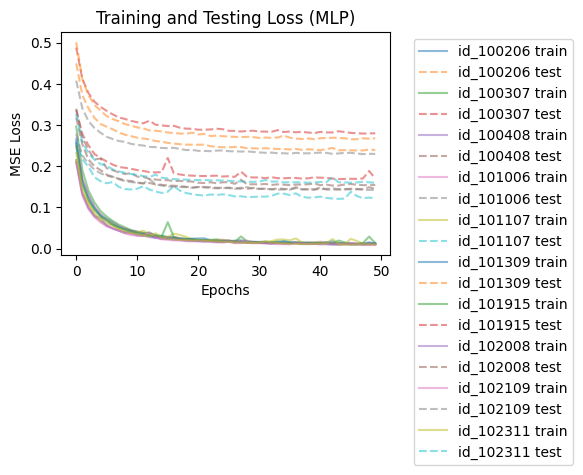

In [6]:
# --- Visualize learning curves ---

#results = np.load(results_path, allow_pickle=True).item()

plt.figure(figsize=(6,4))
for sid, vals in results.items():
    plt.plot(vals["train_loss"], label=f"{sid} train", alpha=0.5)
    plt.plot(vals["test_loss"], label=f"{sid} test", linestyle="--", alpha=0.5)

plt.title(f"Training and Testing Loss ({method})")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Example simulate single subject time series

In [7]:
# Single subject plots
sig_path = os.path.join(preproc_dir, f"{subjects[0]}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{subjects[0]}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{subjects[0]}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{subjects[0]}_MLP.pt")

Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)

In [8]:
S=3 #number of steps
N=Z.shape[1] #number of regions
Zsim = NPI.model_time_series(model, np.zeros((S,N)), tlen=4600, noise_strength=0.1)
Zsim.shape

(4603, 450)

In [9]:
# Empirical vs simulated time series, FC, and dFC

def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1)
    gz=stats.zscore(tseries)
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def dFC(tseries):
    return np.corrcoef(go_edge(tseries))

test_dur=3000 #int(len(Z)-len(Z)/100*80) #3000

emp=Z[-test_dur:,:]
sim=Zsim[-test_dur:,:]

FC_emp=np.corrcoef(emp.T)
FC_sim=np.corrcoef(sim.T)

dFC_emp=dFC(emp)
dFC_sim=dFC(sim)

In [10]:
FC_emp.shape

(450, 450)

In [11]:
dFC_emp.shape

(3000, 3000)

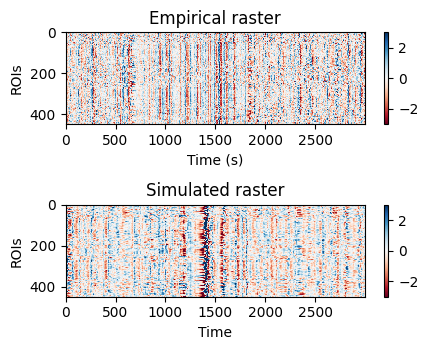

In [12]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow(stats.zscore(emp,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow(stats.zscore(sim,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')
#plt.axis('off')
plt.tight_layout()
plt.show()

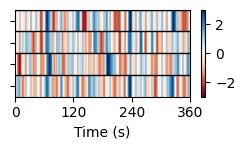

In [13]:
dura=501
plt.figure(figsize=(2.6,1.6))
plt.imshow(stats.zscore(emp,axis=0)[-dura:,-4:].T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.axhline(-0.49,linewidth=1,c='k')
plt.axhline(.49,linewidth=1,c='k')
plt.axhline(1.49,linewidth=1,c='k')
plt.axhline(2.49,linewidth=1,c='k')
plt.colorbar()
plt.xlabel('Time (s)')
for i in np.arange(dura)[::15]:
    plt.axvline(i+0.5,linewidth=.25,c='k')
plt.yticks([0,1,2,3],['','','',''])
plt.xticks([0,dura/3,2*dura/3,dura],[0,int(dura/3*0.72),int(2*dura/3*0.72),int(dura*0.72)])
#plt.axis('off')
plt.tight_layout()
#plt.savefig('Emp_signals.png',dpi=300, transparent=True)
plt.show()

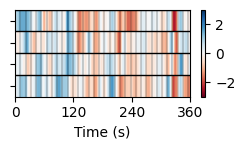

In [14]:
dura=501
plt.figure(figsize=(2.6,1.6))
plt.imshow(stats.zscore(sim,axis=0)[-dura:,-4:].T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.axhline(-0.49,linewidth=1,c='k')
plt.axhline(.49,linewidth=1,c='k')
plt.axhline(1.49,linewidth=1,c='k')
plt.axhline(2.49,linewidth=1,c='k')
plt.colorbar()
plt.xlabel('Time (s)')
for i in np.arange(dura)[::15]:
    plt.axvline(i+0.5,linewidth=.25,c='k')
plt.yticks([0,1,2,3],['','','',''])
plt.xticks([0,dura/3,2*dura/3,dura],[0,int(dura/3*0.72),int(2*dura/3*0.72),int(dura*0.72)])
#plt.axis('off')
plt.tight_layout()
#plt.savefig('Sim_signals.png',dpi=300, transparent=True)
plt.show()

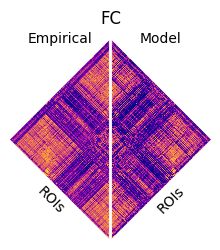

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# FC_emp and FC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = 0, 1

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(FC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(FC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'FC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()

In [ ]:
np.corrcoef(FC_emp[np.triu_indices(450,1)],FC_sim[np.triu_indices(450,1)])

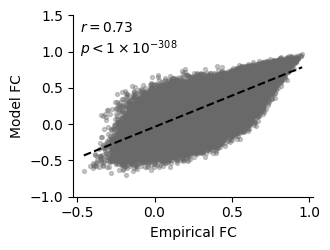

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(FC_emp, k=1)
x = FC_emp[tri].astype(float).ravel()
y = FC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# stats
r, p = pearsonr(x, y)
lr = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr, intercept_stderr

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))
ax.scatter(x, y, s=8, alpha=0.35,c='dimgray')

# regression line
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, lr.slope * xx + lr.intercept, linewidth=1.5,c='k',linestyle='--')

# identity line for reference
#lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
#ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=1)

ax.set_xlabel('Empirical FC')
ax.set_ylabel('Model FC')
#ax.set_title('Empirical vs. Model FC')

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"   # avoids log10(0)
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# annotate correlation + p-value
ax.text(0.03, 0.97, rf"$r = {r:.2f}$" + "\n" + p_str,
        transform=ax.transAxes, ha="left", va="top")

# turn off top and right axes spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ticks = ax.get_xticks()
ax.set_yticks(ticks)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim_scatter.png',dpi=300, transparent=True)
plt.show()

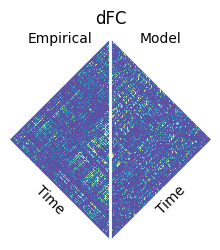

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# dFC_emp and dFC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = -0, 1.

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(dFC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(dFC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'dFC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()

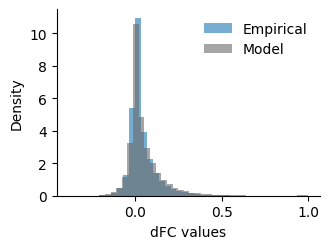

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(dFC_emp, k=1)
x = dFC_emp[tri].astype(float).ravel()
y = dFC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# --- KS test ---
D, p = ks_2samp(x, y)

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))

# histograms
bins = 40
ax.hist(x, bins=bins, alpha=0.6, label="Empirical", density=True)
ax.hist(y, bins=bins, alpha=0.6, label="Model", density=True, color='dimgray')

ax.set_xlabel('dFC values')
ax.set_ylabel('Density')

# annotate KS test results
#ax.text(0.03, 0.97, rf"$D = {D:.2f}$" + "\n" + p_str,
#        transform=ax.transAxes, ha="left", va="top")

# tidy up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend (move outside the plot to avoid overlap)
# Put legend at upper right, labels below the boxes
# shrink current axis by 20% (leave room on the right)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# now put legend to the right
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim_hist.png', dpi=300, transparent=True)
plt.show()

# All Subjects (I only removed subject 6 because it does not fit well!)

In [19]:
# Empirical static and dynamic FC for all subjects
FCs_emp={}
dFCs_emp={}
FCs_sim={}
dFCs_sim={}
for isu in range(len(subjects)):
  sig_path = os.path.join(preproc_dir, f"{subjects[isu]}_signals.npy")
  inp_path = os.path.join(preproc_dir, f"{subjects[isu]}_inputs.npy")
  tgt_path = os.path.join(preproc_dir, f"{subjects[isu]}_targets.npy")
  mdl_path = os.path.join(models_dir,  f"{subjects[isu]}_MLP.pt")

  Z = np.load(sig_path)
  X = np.load(inp_path)             # (M, S*N)
  Y = np.load(tgt_path)             # (M, N)

  # Load model
  model = load_model(mdl_path, X, Y)

  S=3 #number of steps
  N=Z.shape[1] #number of regions
  Zsim = NPI.model_time_series(model, np.zeros((S,N)), tlen=4600, noise_strength=.1)

  test_dur=3000 #int(len(Z)-len(Z)/100*80)

  emp=Z[-test_dur:,:]
  sim=Zsim[-test_dur:,:]

  FCs_emp[isu]=np.corrcoef(emp.T)
  FCs_sim[isu]=np.corrcoef(sim.T)

  dFCs_emp[isu]=dFC(emp)
  dFCs_sim[isu]=dFC(sim)

In [20]:
T=emp.shape[0]   # time points
N=emp.shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

In [21]:
Corr_FC_emp_VS_sim={}
Fluidity_emp={}
Fluidity_sim={}
for isu in np.delete(np.arange(10),6):
  Corr_FC_emp_VS_sim[isu]=stats.pearsonr(FCs_emp[isu][tri_N],FCs_sim[isu][tri_N])[0]
  Fluidity_emp[isu]=np.var(dFCs_emp[isu][tri_T])
  Fluidity_sim[isu]=np.var(dFCs_sim[isu][tri_T])

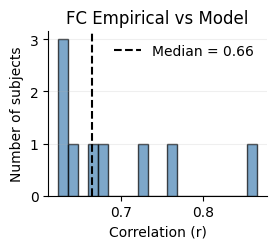

In [22]:
data = np.asarray(list(Corr_FC_emp_VS_sim.values()))

# --- Plot histogram ---
fig, ax = plt.subplots(figsize=(3, 2.6))

ax.hist(data, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.median(data), color='k', linestyle='--', lw=1.5, label=f"Median = {np.median(data):.2f}")

# Cosmetic tweaks
ax.set_title('FC Empirical vs Model')
ax.set_xlabel("Correlation (r)")
ax.set_ylabel("Number of subjects")
#ax.set_xlim(0.7, 1.0)
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

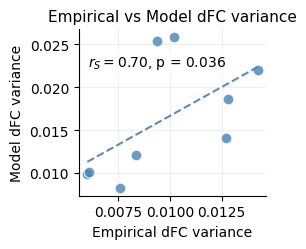

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# --- align subjects present in both ---
idx = sorted(set(Fluidity_emp.keys()) & set(Fluidity_sim.keys()))
x = np.array([Fluidity_emp[i] for i in idx], float)  # empirical
y = np.array([Fluidity_sim[i] for i in idx], float)  # model

# --- Scatter plot ---
fig, ax = plt.subplots(figsize=(2.9, 2.6))

sc = ax.scatter(x, y, s=60, color='steelblue',
                edgecolor='white', linewidth=0.9, alpha=0.8)

# --- Regression line ---
lr = linregress(x, y)
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, lr.slope*xx + lr.intercept, color='steelblue',
        linewidth=1.5, linestyle="--", alpha=0.9)

# --- Identity line (y=x) ---
#lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
#ax.plot([lo, hi], [lo, hi], ls="--", lw=1, color="k", alpha=0.4)
#ax.set_xlim(lo, hi)
#ax.set_ylim(lo, hi)

# --- Correlation ---
r, p = stats.spearmanr(x, y)
ax.text(0.05, 0.85, f"$r_S = {r:.2f}$, p = {p:.2g}",
        transform=ax.transAxes, va='top', ha='left', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

# --- Labels & style ---
ax.set_xlabel("Empirical dFC variance")
ax.set_ylabel("Model dFC variance")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.2)
ax.set_title("Empirical vs Model dFC variance", fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
#EC_t = NPI.model_ECt(model, input_X=X[:400,:], target_Y=Y[:400,:], pert_strength=0.1)

In [ ]:
#EC_t.shape

(400, 450, 450)